In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np

## Climate Change : Linear regression analysis

What causes global warning? We used the dataset "globalWarm3.csv" data to gain insight into the problem. 

In [2]:
data_set = pd.read_csv('globalWarm3.csv')
data_set['log_temp'] = np.log(data_set['Temp'])
data_set.head()

,Year,Temp,CO2,Solar,Transmission,IceShelf,log_temp
0,1980,19,338.57,1366.51,0.929667,7.85,2.944439
1,1981,26,339.92,1366.51,0.929767,7.25,3.258097
2,1982,4,341.30,1366.16,0.853067,7.45,1.386294
3,1983,25,342.71,1366.18,0.897717,7.52,3.218876
4,1984,9,344.24,1365.71,0.916492,7.17,2.197225


In [3]:
data_set.shape

(31, 7)

In [4]:
data_set.dropna(axis=0, inplace = True)

In [5]:
data_set.columns

Index(['Year', 'Temp', 'CO2', 'Solar', 'Transmission', 'IceShelf', 'log_temp'], dtype='object')

In [6]:
data_set.dropna(inplace = True)
data_set.shape

(30, 7)

In order to have a quick glance at the dataset we first drew a scatter plot of the following variables in a lattice: Temp, CO2, Solar, Transmission, and IceShelf. 
    
The variables represent the following:
- Temp = annual surface temperature measured in $1/100^{\circ} C$ over the 1950-1980 mean.
- Solar = annual mean intensity of sunlight piercing the atmosphere 
- CO2 = annual average fraction CO2 in atmosphere (#molecules/#molecules of dry air) 
- IceShelf = sea ice in 1MM square miles hypothesized to reflect heat 
- Transmission = volcanic MLO transmission data where eruptions release greenhouse gases but also decrease the temperature 

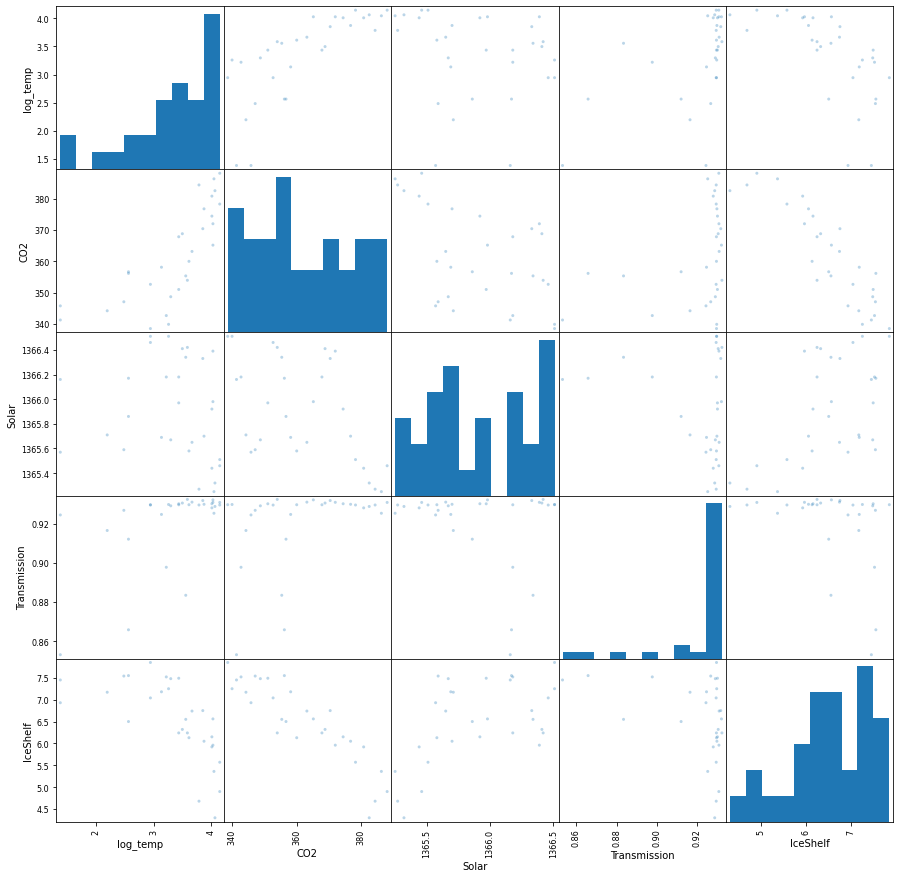

In [7]:
scatter_matrix(data_set[['log_temp', 'CO2', 'Solar', 'Transmission', 'IceShelf']], alpha=0.3, figsize=(15, 15),
               diagonal='hist')
plt.show()

As we can see from the scatter plots, there seems to be a linear relationship both between CO2 and IceShelf and Solar and IceShelf. Since this could bring indicate a multicolinearity problem in the upcoming steps of the analysis, we thought it would be useful to analyze the correlation matrix of the dataset. 

As we can see from the results below, the correlation index in both cases is high.

Last but not least, notice that the correlation of the dependent variable and both CO2 and ICShelf is high in absolute terms. We should keep this in mind once we have to choose the independent variables of the model.

We will now check if there is evidence of whether certain interaction between the independent variables 

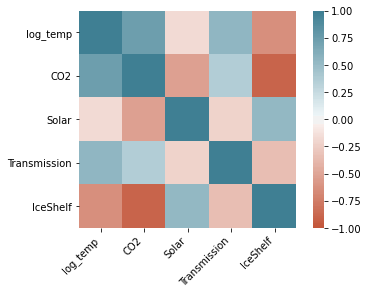

In [8]:
import seaborn as sns

features = ['log_temp','CO2','Solar','Transmission','IceShelf']
corr = data_set[features].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.show()

We begin to select the features we will include in our final model by performing univariate feature selection. It selects the best features based on univariate statistical tests. The variables are set in order of importance according to this test.

In [9]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

features = ['CO2','Solar','Transmission','IceShelf']
X = data_set[features]
Y = data_set[['log_temp']]
skb = SelectKBest(f_regression, k=4)
skb.fit(X, Y)

best_features = np.where(skb.get_support())[0]
[features[i] for i in best_features]

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


['CO2', 'Solar', 'Transmission', 'IceShelf']

We also performed recursive feature elimination (or RFE). RFE selects features by recursively considering smaller and smaller sets of features. 

First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ (e.g., Linear regression) attribute or through a feature_importances_ (e.g., Random Forest) attribute. 

Then, the least important features are pruned from current set of features.
That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

As we can see from the results, the model independent variables suggested by the analysis are  ['CO2', 'Solar', 'Transmission']. Notice that the variable IceShelf hast been excluded.

In [10]:
from sklearn.feature_selection import RFE  
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [11]:
X.shape

(30, 4)

In [12]:
lm = LinearRegression()
rfe = RFE(estimator=lm, n_features_to_select=3, step=1)
rfe.fit(X, Y)
best_features = np.where(rfe.get_support())[0]
[features[i] for i in best_features]

['Solar', 'Transmission', 'IceShelf']

Finally, we decided to plot the output of several feature combinations and their corresponding R2 adjusted and information criteria results. We will pick one among the models with highest R2 adjusted and lower AIC and BIC. 

In [13]:
print(X.shape, Y.shape)

(30, 4) (30, 1)


('CO2',) 46.63 49.44 0.54
('Solar',) 70.24 73.04 -0.01
('Transmission',) 60.62 63.43 0.27
('IceShelf',) 55.75 58.56 0.38
('CO2', 'Solar') 43.83 48.03 0.6
('CO2', 'Transmission') 42.25 46.46 0.62
('CO2', 'IceShelf') 48.37 52.57 0.53
('Solar', 'Transmission') 62.51 66.71 0.25
('Solar', 'IceShelf') 55.7 59.91 0.4
('Transmission', 'IceShelf') 51.15 55.36 0.48
('CO2', 'Solar', 'Transmission') 37.63 43.23 0.68
('CO2', 'Solar', 'IceShelf') 45.81 51.42 0.58
('CO2', 'Transmission', 'IceShelf') 43.71 49.32 0.61
('Solar', 'Transmission', 'IceShelf') 50.19 55.8 0.51
('CO2', 'Solar', 'Transmission', 'IceShelf') 39.52 46.52 0.67
(15, 3)


<ipython-input-14-39ba204f28a5>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  models = np.array(model)


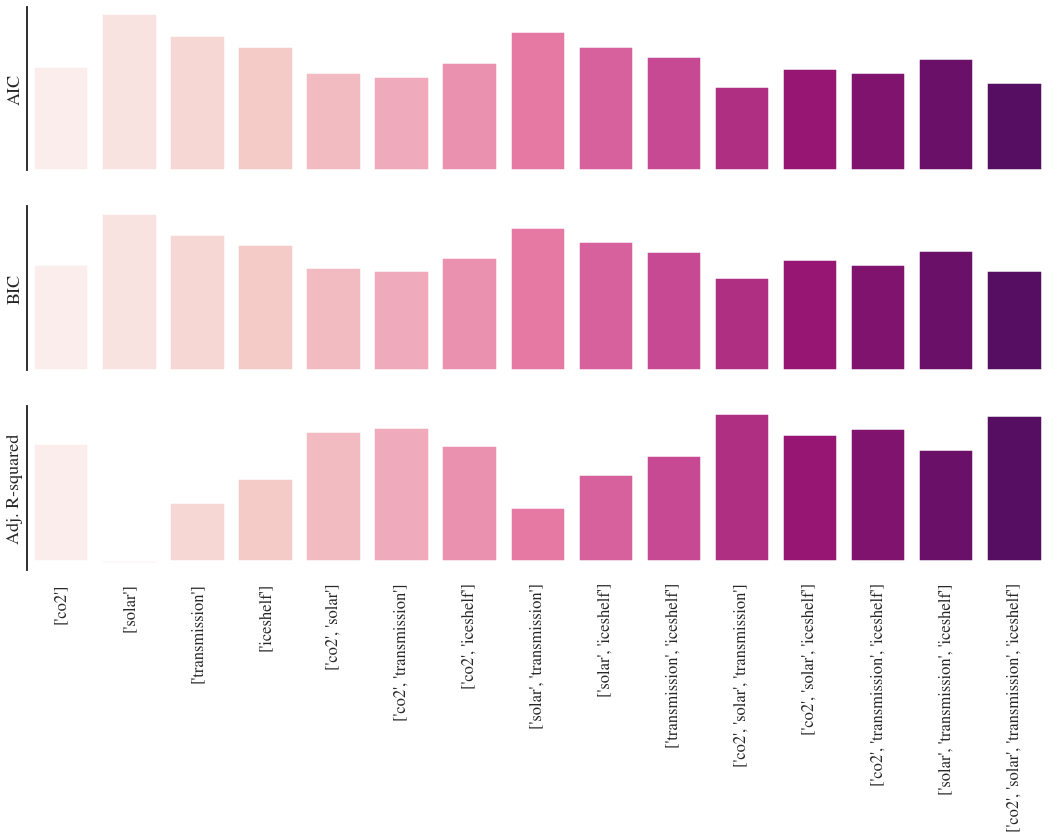

In [14]:
import itertools
fit = []
model = []

for L in range(1, len(features)+1):    #Number of predictors in each model
    for regressors in itertools.combinations(features, L):  #Generating combinations
        model.append(list(regressors))
        X = sm.add_constant(data_set[list(regressors)].values)
        res = sm.OLS(Y,X).fit()
        fit.append(res)
        print(regressors,round(res.aic,2),round(res.bic,2),round(res.rsquared_adj,2))
        
olsresults = []
for l in fit: 
    olsresults.append([l.aic, l.bic,  l.rsquared_adj ])

print (np.array(olsresults).shape)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set(style="white", font='StixGeneral', context="talk")
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
models = np.array(model)
mod = np.arange(len(models))

sns.barplot(mod,np.array(olsresults)[:,0], ci=None, palette="RdPu",  ax=ax1)
ax1.set_ylabel('AIC'); ax1.set_xlabel(''); 
sns.barplot(mod,np.array(olsresults)[:,1], ci=None, palette="RdPu",  ax=ax2)
ax2.set_ylabel('BIC'); ax2.set_xlabel('')

sns.barplot(mod,np.array(olsresults)[:,2], ci=None, palette="RdPu",  ax=ax3)
ax3.set_ylabel('Adj. R-squared'); ax3.set_xlabel('')
sns.despine(bottom=True)
plt.setp(f.axes, yticks=[], xticklabels=[[j.lower() for j in i] for i in model])
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.tight_layout(h_pad=2)

In [15]:
print ("Minimum AIC: " , np.argmin(np.array(olsresults)[:,0]))
print ("Minimum BIC: " , np.argmin(np.array(olsresults)[:,1]))
print ("Maximum Adjusted R^2: " , np.argmax(np.array(olsresults)[:,2]))

print ("The model with the optimal criteria according to AIC and BIC: ", np.array(model)[10])
print ("The model with the optimal criteria according to Adj - R^2: ", np.array(model)[10])
#BIC statistic generally places a heavier penalty on models with many variables, 
#and hence results in the selection of smaller models
print("")

Minimum AIC:  10
Minimum BIC:  10
Maximum Adjusted R^2:  10
The model with the optimal criteria according to AIC and BIC:  ['CO2', 'Solar', 'Transmission']
The model with the optimal criteria according to Adj - R^2:  ['CO2', 'Solar', 'Transmission']



<ipython-input-15-4f37d31b8ad8>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print ("The model with the optimal criteria according to AIC and BIC: ", np.array(model)[10])
<ipython-input-15-4f37d31b8ad8>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print ("The model with the optimal criteria according to Adj - R^2: ", np.array(model)[10])


We will now compute a multiple linear regression model of log(Temp) against the other variables suggested by the analysis performed above. 

We computed pairwise interactions between variables and checked if there was any that should be included in the model. 

We found that the interaction between transmission and solar could be included in the model once transmission is removed. If we include both independent variables in the model, the residuals reject Jarque-Bera's normality test and Durbin-Watson's test indicates evidence of autocorrelation. 

In [16]:
import statsmodels.api as sm
import numpy as np

In [17]:
# Prepare the dataset
features = ['CO2', 'Solar', 'Transmission']
X = data_set[features]
Y = data_set[['log_temp']] 

#### Linear Regression

In [18]:
f = 'log_temp ~ CO2 + Solar + Transmission '
model = sm.OLS.from_formula( formula=f , data = data_set)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               log_temp   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     21.57
Date:                Tue, 06 Apr 2021   Prob (F-statistic):           3.16e-07
Time:                        16:48:47   Log-Likelihood:                -14.813
No. Observations:                  30   AIC:                             37.63
Df Residuals:                      26   BIC:                             43.23
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -812.4421    312.996     -2.596   

#### Interpreting above results

*Constant/Intercept*  - Estimated mean Y(logTemp) value when all X's(attributes) are 0. 

*$R^2$*   and Adj. R-squared* -  An $R^2$ of 0.713 that the regression model perfectly fits the data quite well. The variability explained by the model is not perfect. We should explore adding other variables to the analysis or explore the residuals to see if there are any anomalies. 

*p-values for coefficient* - p-value for the coefficientes are < 0.05, which means they are  statistically significant. 

*F-statistic* - Prob (F-statistic)* - It indicates that the all the explanatory variables we have chosen are statistically relevant together to explain y. 

*Coefficiets or Betas:* - P value < 0.05 indicates that they are statistically significant 

In [19]:
# Compute pairwise interactions
pairwise_list = ['CO2','Solar','Transmission','IceShelf']
new_list=['log_temp']
for i in pairwise_list:
    for j in pairwise_list:
        data_set[i+j] = data_set[i]*data_set[j]
        new_list.append(i+j)


In [20]:
lm = LinearRegression()
rfe = RFE(estimator=lm, n_features_to_select=3, step=1)
rfe.fit(data_set[new_list[1:]], data_set[new_list[0]])
best_features = np.where(rfe.get_support())[0]
[new_list[1:][i] for i in best_features]

['TransmissionSolar', 'TransmissionTransmission', 'TransmissionIceShelf']

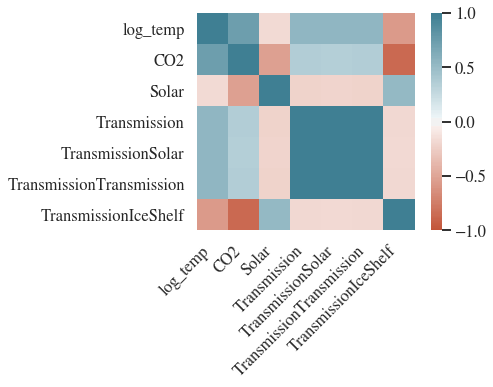

In [21]:
new_list = ['log_temp','CO2','Solar','Transmission',
            'TransmissionSolar','TransmissionTransmission', 'TransmissionIceShelf']
corr = data_set[new_list].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.show()

In [22]:
data_set.columns

Index(['Year', 'Temp', 'CO2', 'Solar', 'Transmission', 'IceShelf', 'log_temp',
       'CO2CO2', 'CO2Solar', 'CO2Transmission', 'CO2IceShelf', 'SolarCO2',
       'SolarSolar', 'SolarTransmission', 'SolarIceShelf', 'TransmissionCO2',
       'TransmissionSolar', 'TransmissionTransmission', 'TransmissionIceShelf',
       'IceShelfCO2', 'IceShelfSolar', 'IceShelfTransmission',
       'IceShelfIceShelf'],
      dtype='object')

In [23]:
f2 = 'log_temp ~ CO2 + Solar  + TransmissionSolar '
model2 = sm.OLS.from_formula( formula=f2 , data = data_set)
results2 = model2.fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:               log_temp   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     21.57
Date:                Tue, 06 Apr 2021   Prob (F-statistic):           3.17e-07
Time:                        16:48:50   Log-Likelihood:                -14.813
No. Observations:                  30   AIC:                             37.63
Df Residuals:                      26   BIC:                             43.23
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          -801.1253    312.84

##### Analysis of the residuals

The histogram of the results suggest that they follow a normal distribution, slighlty negative skewed (left skewed). 

For verifying the Normality assumption, we produced a QQplot of the sample quantiles against the theoretical quantiles from a normal distribution. In the core part of the plot, the relationship is tight with the theoretical quantiles. While some dots diverge at the lowest part of the quantile plot, it represents an extreme in the distribution. We conclude that the Normality assumption is valid.

There is no linear relation between the residuals and the fitted values. This suggests that there are no missing explanatory that have a significan correlation with the variables already included in the linear regression model.

Moreover, the residuals are roughly form a "horizontal band" around the 0 line. This suggests that the variances of the error terms are equal.

There are residuals that stand out from the basic random pattern of residuals. This suggests that there are outliers. They can be identified influential plot. In order to draw a propper conclusion on them, we should investigate further and see what happened during those years. 

In order to address them, we should look at each of them individually.The leverage and the influential plots suggests that there are three outliers. This may be the cause why the R2 is still not that close to one. A data point is influential if it unduly influences any part of a regression analysis, such as the predicted responses, the estimated slope coefficients, or the hypothesis test results.

##### Analysis if the residuals: Check Normality

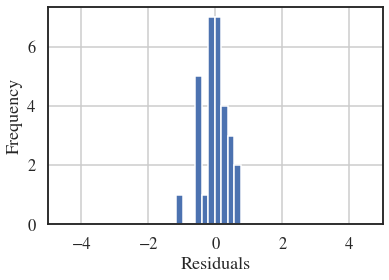

In [30]:
# Histogram
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.xlim(-,5)
plt.grid(True)
plt.hist(results.resid)
plt.show()

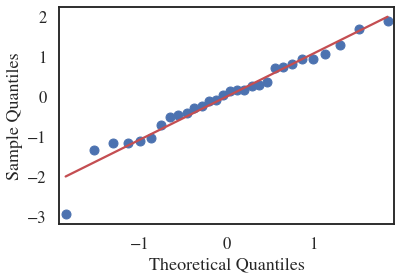

In [25]:
# QQ Plot
fig = sm.qqplot(results.resid, fit=True, line='r')
plt.show()

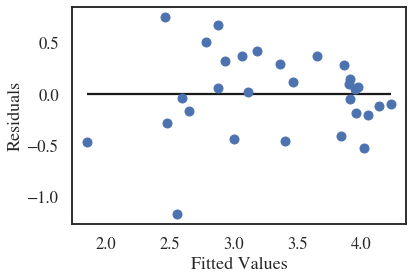

In [26]:
# Residuals vs. Fittied Data --- There is no linear relation between the residuals and the fitted values
plt.plot(results.fittedvalues,  results.resid,'o')
plt.hlines(xmin=np.min(results.fittedvalues),xmax=np.max(results.fittedvalues),y=0)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

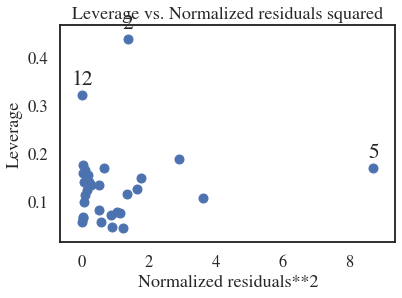

In [27]:
#Leverage Plot: it shows data points that influence the residuals.
from statsmodels.graphics.regressionplots import plot_leverage_resid2
fig = plot_leverage_resid2(results)
plt.show()

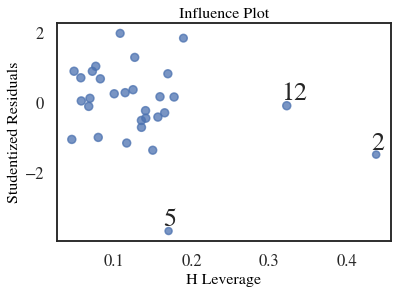

In [28]:
# Influence Plot
from statsmodels.graphics.regressionplots import influence_plot
influence_plot(results,size = 7)
plt.show()

<ipython-input-29-2ad5c2123730>:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(np.arange(len(c)), c, markerfmt=",")


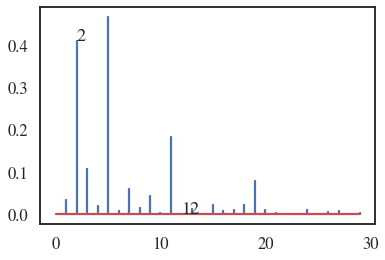

In [29]:
# Cooks distance -  is also used estimate of the influence of a data point
influence = results.get_influence()
#c is the distance and p is p-value
(c, p) = influence.cooks_distance
plt.annotate("2",(2,c[2]))
plt.annotate("12",(12,c[12]))
plt.stem(np.arange(len(c)), c, markerfmt=",")
plt.show()

Based on the results from suggested by R2, R2 adjusted and the information criteria we picked or final model.

The model with the optimal criteria according to AIC and BIC:  ['CO2', 'Solar','Transmission']
The model with the optimal criteria according to Adj - R^2:  ['CO2', 'Solar', 'Transmission']

- Based on the regression output , CO2 is the major variable that explains the rise of global.

- Based on the the correlation matrix, we can see that the variable IceShelf (sea ice in 1MM square miles hypothesized to reflect heat) should be included in the model. However, there is a very strong correlation between this and CO2. The linear bond is so strong that it is not possible to include both in the model. We picked the one that individually explains a higher percentage of the variance of IceShelf, that is CO2. 

- The annual mean intensity of sunlight piercing the atmosphere (Solar) and volcanic MLO transmission (Transmission) contribute further less to raising global temperature, but since they are still statistically significant.  
